In [70]:
import pandas as pd
import numpy as np
from datetime import date
import csv 
import requests
import glob
from pandas import DataFrame, concat
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import requests
import os.path, time
from util import select_relevant_rows, select_attributes, read_movement_data, read_multiple_csv,download_updated_mobility_data, download_updated_mobility_data

# fix for 'package not found' when installing in Anaconda environment
if 'google.colab' not in str(get_ipython()):
    import pip
    pip.main(['install', 'xgboost'])

if 'google.colab' in str(get_ipython()):
  !rm util.py
  !wget https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/util.py

from xgboost import XGBRegressor

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [71]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

In [72]:
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
    )

In [73]:
list(region_focus_data)

['data',
 'stato',
 'codice_regione',
 'denominazione_regione',
 'lat',
 'long',
 'ricoverati_con_sintomi',
 'terapia_intensiva',
 'totale_ospedalizzati',
 'isolamento_domiciliare',
 'totale_positivi',
 'variazione_totale_positivi',
 'nuovi_positivi',
 'dimessi_guariti',
 'deceduti',
 'casi_da_sospetto_diagnostico',
 'casi_da_screening',
 'totale_casi',
 'tamponi',
 'casi_testati',
 'note',
 'ingressi_terapia_intensiva',
 'note_test',
 'note_casi',
 'totale_positivi_test_molecolare',
 'totale_positivi_test_antigenico_rapido',
 'tamponi_test_molecolare',
 'tamponi_test_antigenico_rapido',
 'codice_nuts_1',
 'codice_nuts_2']

In [74]:
frame_interesting_columns = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi','deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
    ])

In [75]:
frame_interesting_columns.head()

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,variazione_totale_positivi,nuovi_positivi,deceduti,tamponi,ingressi_terapia_intensiva
4,2020-02-24T18:00:00,10,2,12,0,18,0,148,NaN
25,2020-02-25T18:00:00,15,2,17,8,8,0,391,NaN
46,2020-02-26T18:00:00,20,3,23,20,21,1,577,NaN
67,2020-02-27T18:00:00,36,6,42,50,50,1,1033,NaN
88,2020-02-28T18:00:00,56,6,62,47,48,2,1277,NaN


In [76]:
frame_interesting_columns = pd.DataFrame(frame_interesting_columns)
frame_interesting_columns['data'] = pd.to_datetime(frame_interesting_columns['data'])
frame_interesting_columns['data'] = frame_interesting_columns['data'].dt.strftime(r'%Y-%m-%d')


In [77]:
# 'tamponi' is cumulative, revert to incidence
columns_to_normalize = ['deceduti', 'tamponi']

for column in columns_to_normalize:
    frame_interesting_columns[column] = frame_interesting_columns[column].transform(
        lambda s: s.sub(s.shift().fillna(0)).abs()
        )


In [78]:
mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

download_updated_mobility_data(
    mobility_data_url,
    file_path,
    region_mobility_path,
    mobility_data_zip_url,
    zip_path
    )

mobility_df = read_movement_data(
    region_mobility_path,
    'IT_Region_Mobility_Report',
    region='Emilia-Romagna')


Data already up to date...


In [79]:
list(mobility_df)

['country_region_code',
 'country_region',
 'sub_region_1',
 'sub_region_2',
 'metro_area',
 'iso_3166_2_code',
 'census_fips_code',
 'place_id',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

In [80]:
mobility_df = mobility_df[['date',
            'retail_and_recreation_percent_change_from_baseline',
            'grocery_and_pharmacy_percent_change_from_baseline',
            'parks_percent_change_from_baseline',
            'transit_stations_percent_change_from_baseline',
            'workplaces_percent_change_from_baseline',
            'residential_percent_change_from_baseline']]

In [81]:
mobility_df.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
3335,2021-01-01,-90.0,-93.0,-67.0,-84.0,-88.0,37.0
3336,2021-01-02,-71.0,-32.0,-63.0,-70.0,-52.0,23.0
3337,2021-01-03,-74.0,-43.0,-43.0,-64.0,-30.0,16.0
3338,2021-01-04,-24.0,19.0,1.0,-45.0,-41.0,16.0
3339,2021-01-05,-52.0,2.0,-46.0,-60.0,-49.0,23.0


In [82]:
frame_interesting_columns.rename(columns={'data': 'date'}, inplace=True)
frame_interesting_columns.set_index('date',inplace=True)

In [83]:
mobility_df.set_index('date',inplace=True)

In [84]:
merged = pd.merge(
    frame_interesting_columns,
    mobility_df,
    on='date'
    )
merged = merged.fillna(0)

In [85]:
list(merged)

['ricoverati_con_sintomi',
 'terapia_intensiva',
 'totale_ospedalizzati',
 'variazione_totale_positivi',
 'nuovi_positivi',
 'deceduti',
 'tamponi',
 'ingressi_terapia_intensiva',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

In [86]:
merged.tail()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,variazione_totale_positivi,nuovi_positivi,deceduti,tamponi,ingressi_terapia_intensiva,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,,
2021-04-21,2116,287,2403,-2430,760,23.0,27263.0,20.0,-28.0,6.0,24.0,-33.0,-14.0,8.0
2021-04-22,2029,282,2311,-2012,1010,28.0,27511.0,18.0,-29.0,7.0,19.0,-33.0,-13.0,8.0
2021-04-23,1948,276,2224,-1972,1104,13.0,28254.0,12.0,-29.0,14.0,31.0,-34.0,-15.0,9.0
2021-04-24,1873,265,2138,-2146,984,30.0,28391.0,10.0,-33.0,10.0,42.0,-33.0,-13.0,7.0
2021-04-25,1842,265,2107,-1922,1001,23.0,16532.0,12.0,-49.0,-25.0,45.0,-41.0,-17.0,7.0


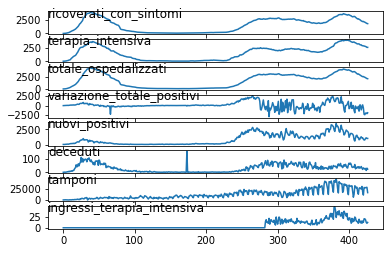

In [87]:
dataset = merged
values = merged.values

groups = range(8)
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups),1,i)
	pyplot.plot(values[:,group])
	pyplot.title(dataset.columns[group],y=0.5,loc='left')
	i += 1
pyplot.show()

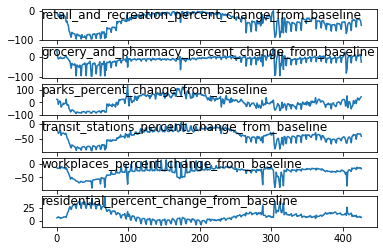

In [88]:
groups = range(8,14)
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups),1,i)
	pyplot.plot(values[:,group])
	pyplot.title(dataset.columns[group],y=0.5,loc='left')
	i += 1
pyplot.show()

In [89]:
column_to_predict = 'terapia_intensiva'

n_days = 100
dataset_reduced = dataset.iloc[-n_days:,:]

y = dataset_reduced[column_to_predict]
X = dataset_reduced

In [90]:
n_predictions = 20

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=n_predictions
    )
regressor = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000
    )

regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
y_pred = regressor.predict(X_test)

/Users/marcomazzoli/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [92]:
mean_absolute_error(y_test, y_pred)

37.89715423583984

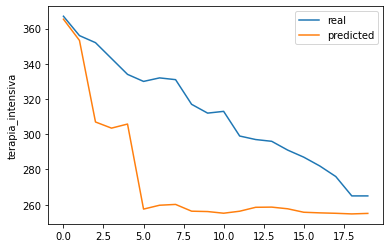

In [93]:
pyplot.plot(y_test.values,label='real')
pyplot.plot(y_pred,label='predicted')
pyplot.ylabel(column_to_predict)
pyplot.legend(loc='best')
pyplot.show()

In [129]:
def select_optimal_window(dataset,column_to_predict):
    result = pd.DataFrame(columns=['mae','prediction_window','train_window'])
    n_predictions = 20
    size = len(dataset) - n_predictions

    for n_predictions in range(1,25,5):
        size = len(dataset) - n_predictions
        for n_days in range(50,size,25):
            dataset_reduced = dataset.iloc[-n_days:,:]

            y = dataset_reduced[column_to_predict]
            X = dataset_reduced
            X = np.ascontiguousarray(X)

            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                shuffle=False,
                test_size=n_predictions
                )
            regressor = XGBRegressor(
                objective='reg:squarederror',
                n_estimators=1000
                )

            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            current_result = {
                'mae':mae,
                'prediction_window':n_predictions,
                'train_window':n_days
                }
            result = result.append(current_result,ignore_index=True)

    return result


In [130]:
result = select_optimal_window(dataset,'terapia_intensiva')

In [122]:
result

,mae,prediction_window,train_window
0,0.119110,1.0,30.0
1,0.082214,1.0,40.0
2,0.193756,1.0,50.0
3,6.790710,1.0,60.0
4,8.840057,1.0,70.0
...,...,...,...
191,24.620076,21.0,360.0
192,9.914667,21.0,370.0
193,6.955973,21.0,380.0
194,4.301179,21.0,390.0


In [131]:
result

,mae,prediction_window,train_window
0,0.193756,1.0,50.0
1,2.626129,1.0,75.0
2,5.154785,1.0,100.0
3,6.068207,1.0,125.0
4,8.386688,1.0,150.0
...,...,...,...
71,22.086929,21.0,300.0
72,21.955039,21.0,325.0
73,22.309254,21.0,350.0
74,5.750458,21.0,375.0
